<a href="https://colab.research.google.com/github/kashishthakur26/Tensorflow-learning/blob/main/transfer_learning_using_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing helper functions


In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-06-02 05:11:42.266034


In [2]:
! nvidia-smi

Fri Jun  2 05:11:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-06-02 16:21:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-02 16:21:50 (80.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2023-06-02 05:11:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 64.233.191.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   208MB/s    in 0.8s    

2023-06-02 05:11:48 (208 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [6]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE = (224,224) 
BATCH_SIZE=32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE
                                                                            )
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)



Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 0: Building a transfer learning model using the keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential order.

But the functional API Gives us more flexibility with our moels.

In [9]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

x = base_model(inputs)
print(f"shape after passing inputs through base model: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

outputs = tf.keras.layers.Dense(10 , activation="softmax" , name="output_layer")(x)

model_0 = tf.keras.Model(inputs , outputs)



16705208/16705208 [==============================] - 0s 0us/step
shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [10]:
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

history_O = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="food_10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/food_10_percent_feature_extraction/20230602-051156
Epoch 1/5
24/24 [==============================] - 20s 236ms/step - loss: 1.8472 - accuracy: 0.4507 - val_loss: 1.2488 - val_accuracy: 0.7516
Epoch 2/5
24/24 [==============================] - 4s 134ms/step - loss: 1.0662 - accuracy: 0.7773 - val_loss: 0.8530 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - 4s 149ms/step - loss: 0.7812 - accuracy: 0.8320 - val_loss: 0.6860 - val_accuracy: 0.8536
Epoch 4/5
24/24 [==============================] - 4s 152ms/step - loss: 0.6254 - accuracy: 0.8693 - val_loss: 0.5991 - val_accuracy: 0.8635
Epoch 5/5
24/24 [==============================] - 7s 285ms/step - loss: 0.5388 - accuracy: 0.8933 - val_loss: 0.5523 - val_accuracy: 0.8602


In [11]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.5538 - accuracy: 0.8600


[0.5537790656089783, 0.8600000143051147]

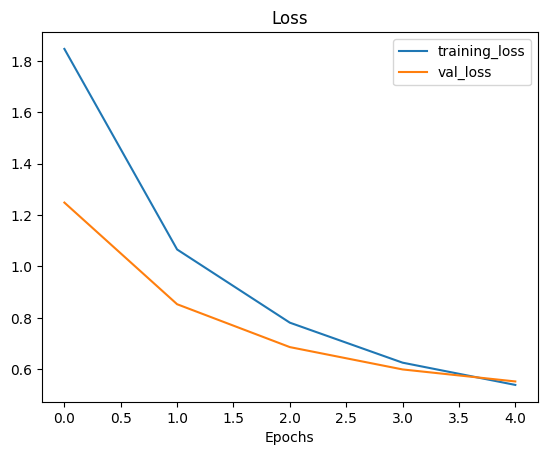

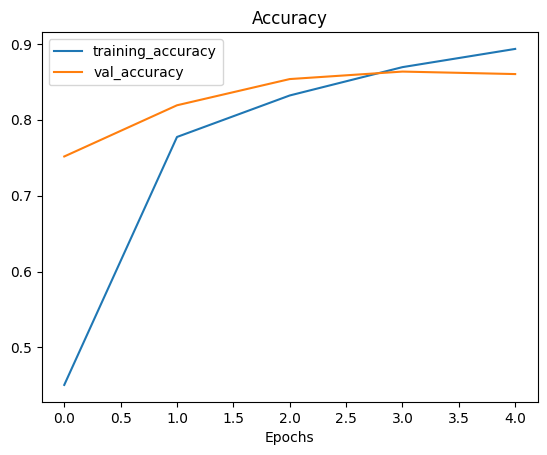

In [12]:
plot_loss_curves(history_O)

## Running a series of transfer learning experiments

1. model-1 : use feature extraction trasnfer learning with 1% of the training data with augmentation
2. model-2 : use feature extraction transfer learning with 10% of the training with data augmnetation
3. model-3 : use fine-tuning transfer learning on 10% of the training data with data augmentation
4. model-4 : use fine-tuning transfer learning on 100% of the training data with data augmentation

In [13]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-06-02 05:12:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 108.177.112.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  53.6MB/s    in 2.4s    

2023-06-02 05:12:58 (53.6 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [14]:
# creating training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [15]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There a

In [16]:
IMG_SIZE=(224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size=32
                                                                           )

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size=32
                                                                           )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model
to add data augmentation right into our models, we can use the layers inside:
* 'tf.keras.layers.experimental.preprocessing()'

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#data augmentation

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
],name="data_augmentation")

(-0.5, 535.5, 359.5, -0.5)

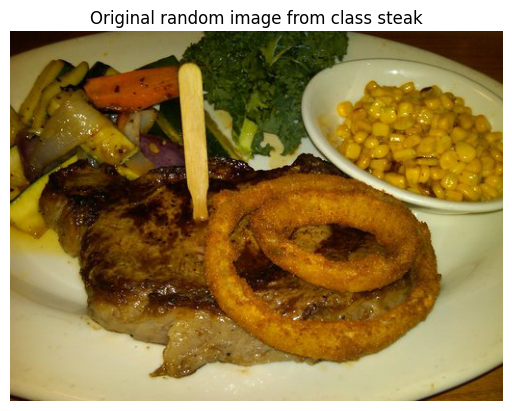

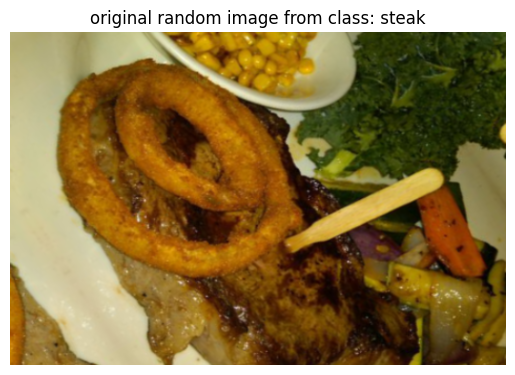

In [18]:
# Visualize our augmented data

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir+"/"+random_image

#read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

#Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img , axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"original random image from class: {target_class}")
plt.axis(False)



In [19]:
## Model 1: feature extraction transfer learning on 1% of the data with data augmentation

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=input_shape , name="input_layer")
x = data_augmentation(inputs)
x = base_model(x , training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs= layers.Dense(10 , activation="softmax" , name="output_layer")(x)

model_1 = keras.Model(inputs ,outputs)

# Compile the model

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230602-051303
Epoch 1/5
79/79 [==============================] - 45s 473ms/step - loss: 1.3435 - accuracy: 0.6360 - val_loss: 0.6637 - val_accuracy: 0.8470
Epoch 2/5
79/79 [==============================] - 29s 364ms/step - loss: 0.6995 - accuracy: 0.8128 - val_loss: 0.4569 - val_accuracy: 0.8783
Epoch 3/5
79/79 [==============================] - 26s 319ms/step - loss: 0.5402 - accuracy: 0.8524 - val_loss: 0.3915 - val_accuracy: 0.9013
Epoch 4/5
79/79 [==============================] - 25s 310ms/step - loss: 0.4759 - accuracy: 0.8656 - val_loss: 0.3159 - val_accuracy: 0.9194
Epoch 5/5
79/79 [==============================] - 22s 275ms/step - loss: 0.4330 - accuracy: 0.8716 - val_loss: 0.3147 - val_accuracy: 0.9112


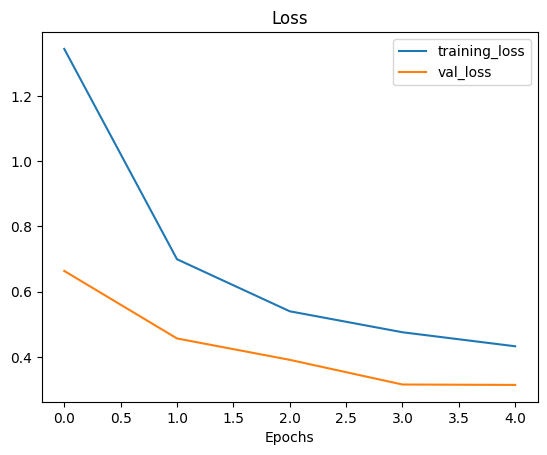

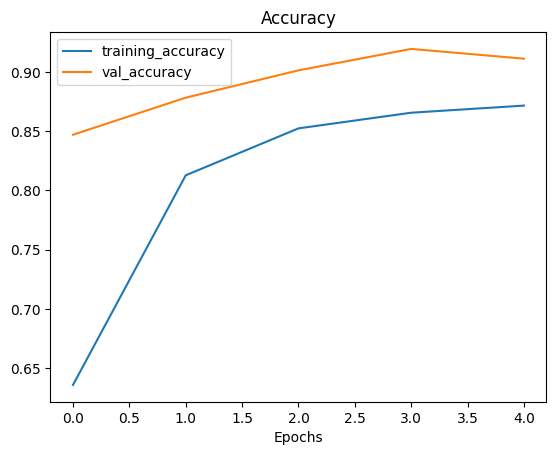

In [20]:
 plot_loss_curves(history_1_percent)

## Model 2 : Feature extraction transfer learning model with 10 percent

In [22]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [23]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2023-06-02 16:22:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   168MB/s    in 1.0s    

2023-06-02 16:22:20 (168 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [24]:
# set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [25]:
# data augmentation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name="data_augmentation")

In [26]:
input_shape=(224,224,3)
base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape , name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10 , activation="softmax" , name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [27]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

## Creating a ModelCheckpoint callback
The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. this is useful so we can come and start where we left off.

In [28]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

### Fit model 2 passing in the modelCheckpoint call back

In [29]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name = "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230602-162228


Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9792 - accuracy: 0.3733
Epoch 1: val_loss improved from inf to 1.40428, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 20s 535ms/step - loss: 1.9792 - accuracy: 0.3733 - val_loss: 1.4043 - val_accuracy: 0.7023
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3091 - accuracy: 0.6707
Epoch 2: val_loss improved from 1.40428 to 0.95550, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 447ms/step - loss: 1.3091 - accuracy: 0.6707 - val_loss: 0.9555 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0060 - accuracy: 0.7587
Epoch 3: val_loss improved from 0.95550 to 0.75179, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 441ms/step - loss: 1.0060 - accuracy: 0.7587 - val

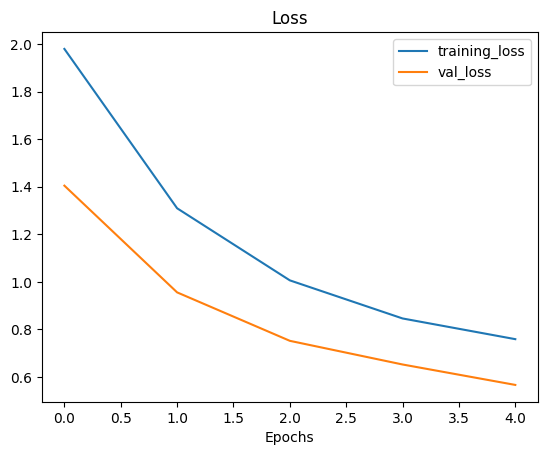

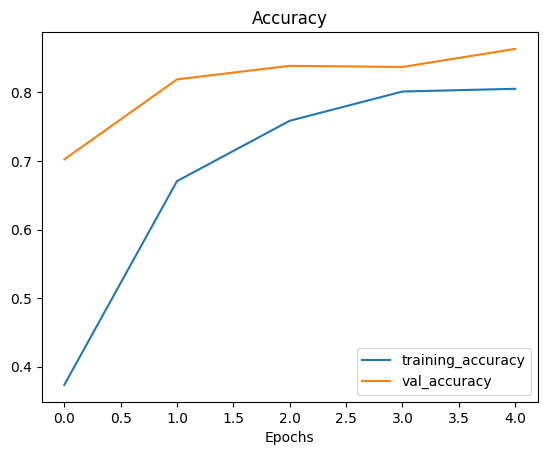

In [30]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpoint weights returns a model to a specific checkpoint.

In [58]:
model_2.load_weights(checkpoint_path)


ValueError: ignored

In [32]:
loaded_weights_model_results = model_2.evaluate(test_data) 

79/79 [==============================] - 7s 79ms/step - loss: 0.6117 - accuracy: 0.8516


In [33]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6117 - accuracy: 0.8516


[0.6116726398468018, 0.8515999913215637]

## model 3 : fine-tuning an existing model on 10 percent of the data

Fine-tuning usually works best after training a feature extraction model 
for a few epochs with large amounts of custom data.

In [34]:
model_2.layers

In [35]:
for layer in model_2.layers:
  print(layer , layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f21b2db0ee0> True
<keras.engine.sequential.Sequential object at 0x7f21b2ddf100> True
<keras.engine.functional.Functional object at 0x7f21b47b2a40> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f21b2ddce50> True
<keras.layers.core.dense.Dense object at 0x7f21b3f643d0> True


In [36]:
for i , layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name , layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [37]:
# setting to last layers trainable
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

In [38]:
for layer_number , layer in enumerate(model_2.layers[2].layers):
  print(layer_number , layer.name  , layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [39]:
print(len(model_2.trainable_variables))

12


In [41]:
# fitting the tunable model
fine_tune_epochs = initial_epochs + 5

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps=int(0.25* len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230602-162553
Epoch 5/10
24/24 [==============================] - 23s 471ms/step - loss: 0.6642 - accuracy: 0.7720 - val_loss: 0.4990 - val_accuracy: 0.8487
Epoch 6/10
24/24 [==============================] - 10s 417ms/step - loss: 0.3617 - accuracy: 0.8813 - val_loss: 0.4225 - val_accuracy: 0.8602
Epoch 7/10
24/24 [==============================] - 8s 332ms/step - loss: 0.2078 - accuracy: 0.9400 - val_loss: 0.4368 - val_accuracy: 0.8536
Epoch 8/10
24/24 [==============================] - 11s 442ms/step - loss: 0.1338 - accuracy: 0.9667 - val_loss: 0.4769 - val_accuracy: 0.8536
Epoch 9/10
24/24 [==============================] - 9s 375ms/step - loss: 0.1103 - accuracy: 0.9693 - val_loss: 0.5057 - val_accuracy: 0.8569
Epoch 10/10
24/24 [==============================] - 9s 349ms/step - loss: 0.1186 - accuracy: 0.9587 - val_loss: 0.4548 - val_accuracy: 0.8635


In [42]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 75ms/step - loss: 0.4716 - accuracy: 0.8576


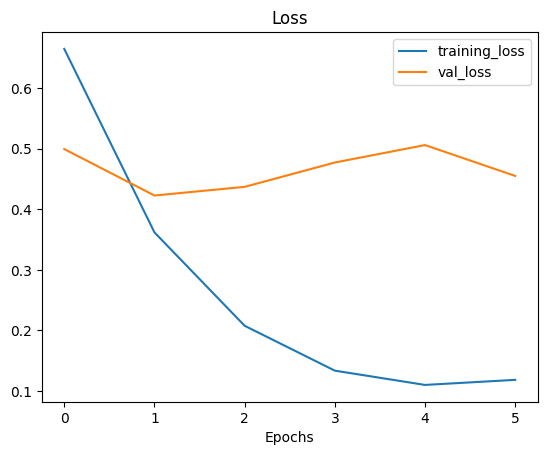

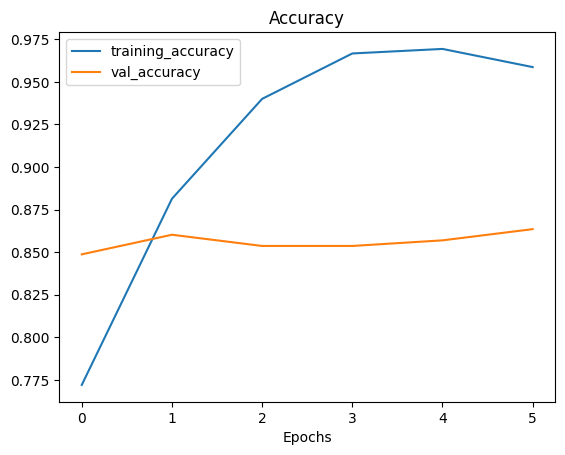

In [45]:
plot_loss_curves(
history_fine_10_percent_data_aug)

In [48]:
import matplotlib.pyplot as plt

def compare_historys(original_history, new_history, initial_epochs=5):
  
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

  
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3733333349227905, 0.6706666946411133, 0.7586666941642761, 0.8013333082199097, 0.8053333163261414, 0.7720000147819519, 0.8813333511352539, 0.9399999976158142, 0.9666666388511658, 0.9693333506584167, 0.9586666822433472]


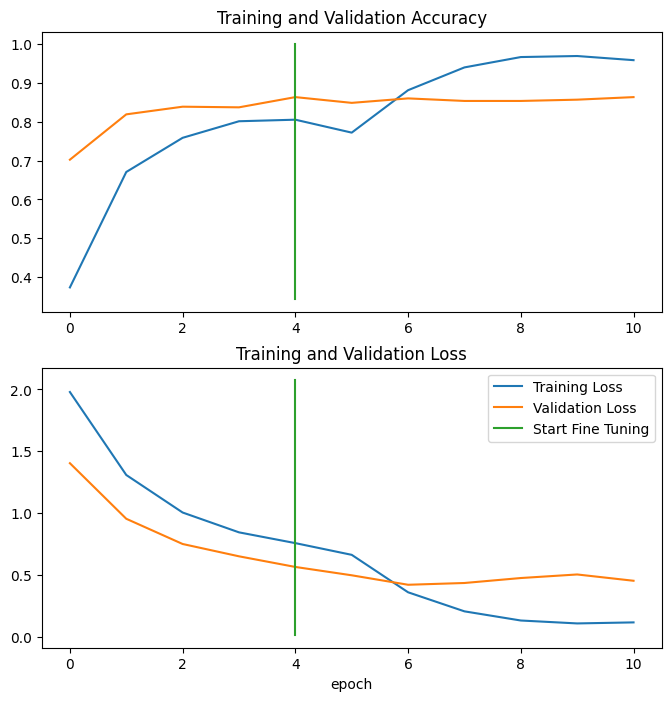

In [49]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

## Model 4: Fine-tuning and existing model on all of the data

In [50]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-06-02 16:39:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  79.3MB/s    in 7.2s    

2023-06-02 16:39:33 (68.3 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [51]:
walk_through_dir("10_food_classes_all_data")


There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.

In [52]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [53]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 85ms/step - loss: 0.4716 - accuracy: 0.8576


[0.4715750515460968, 0.8575999736785889]

In [54]:
results_fine_tune_10_percent

[0.4715750515460968, 0.8575999736785889]

In [57]:
model_2.load_weights(checkpoint_path)

ValueError: ignored

In [56]:
model_2.load_weights(latest_weights)

ValueError: ignored

In [59]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [60]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

In [61]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230602-165651
Epoch 5/10
235/235 [==============================] - 72s 261ms/step - loss: 0.6601 - accuracy: 0.7916 - val_loss: 0.3649 - val_accuracy: 0.8816
Epoch 6/10
235/235 [==============================] - 55s 232ms/step - loss: 0.5161 - accuracy: 0.8308 - val_loss: 0.3545 - val_accuracy: 0.8766
Epoch 7/10
235/235 [==============================] - 51s 217ms/step - loss: 0.4671 - accuracy: 0.8508 - val_loss: 0.3203 - val_accuracy: 0.8865
Epoch 8/10
235/235 [==============================] - 45s 191ms/step - loss: 0.4319 - accuracy: 0.8571 - val_loss: 0.2951 - val_accuracy: 0.9079
Epoch 9/10
235/235 [==============================] - 42s 175ms/step - loss: 0.3807 - accuracy: 0.8789 - val_loss: 0.2964 - val_accuracy: 0.9030
Epoch 10/10
235/235 [==============================] - 41s 173ms/step - loss: 0.3721 - accuracy: 0.8801 - val_loss: 0.3380 - val_accuracy: 0.8931


In [62]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 9s 94ms/step - loss: 0.2757 - accuracy: 0.9060


[0.27570369839668274, 0.906000018119812]

5
11
[0.3733333349227905, 0.6706666946411133, 0.7586666941642761, 0.8013333082199097, 0.8053333163261414, 0.7915999889373779, 0.8307999968528748, 0.8507999777793884, 0.8570666909217834, 0.878933310508728, 0.880133330821991]


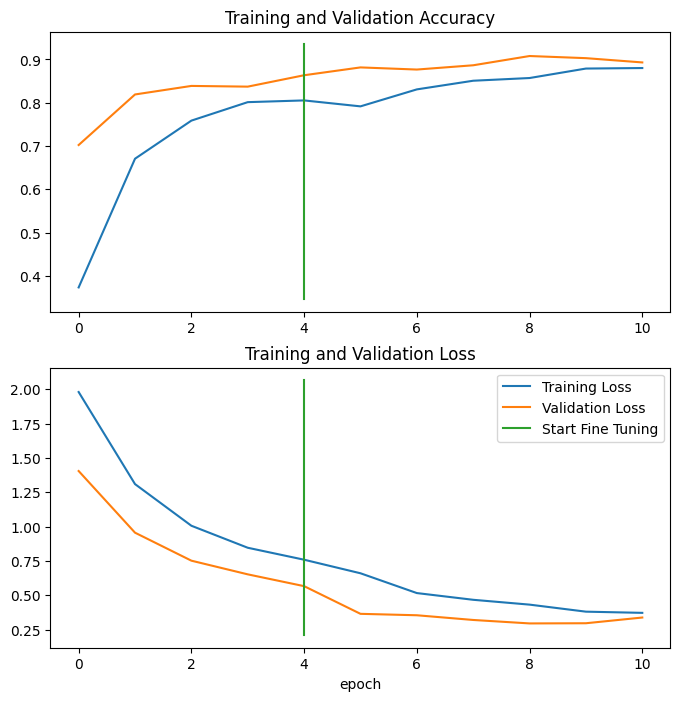

In [63]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)